In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [19]:
stock = 'MSFT'
df = yf.download(stock,'2010-12-01', '2020-12-02')

df['Daily Returns'] = df['Close'].pct_change()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower
Date,,,,,,,,,,
2010-12-01,25.570000,26.250000,25.559999,26.040001,20.703621,74123500,NaN,NaN,NaN,NaN
2010-12-02,26.240000,26.980000,26.200001,26.889999,21.379427,91759200,0.032642,NaN,NaN,NaN
2010-12-03,26.809999,27.059999,26.780001,27.020000,21.482788,52622000,0.004835,NaN,NaN,NaN
2010-12-06,26.930000,26.980000,26.760000,26.840000,21.339668,36264200,-0.006662,NaN,NaN,NaN
2010-12-07,27.080000,27.129999,26.850000,26.870001,21.363522,57860500,0.001118,NaN,NaN,NaN


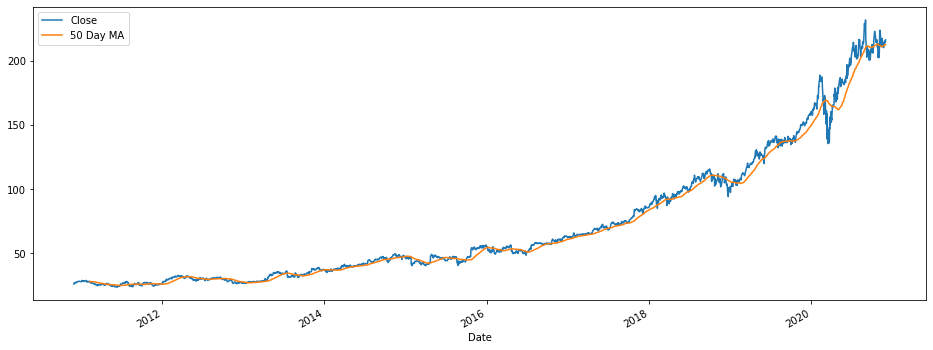

In [20]:
# Bolllinger Analysis Bands

#Close 50 MA

df['50 Day MA'] = df['Close'].rolling(window = 50).mean()

#Upper = 50 MA + 2*std(50 days)

df['Upper'] = df['Close'] + 2*(df['Close'].rolling(50).std())

#Lower = 50 MA - 2*std(50 days)

df['Lower'] = df['50 Day MA'] - 2*(df['Close'].rolling(50).std())

#Plot the Data

df[['Close','50 Day MA']].plot(figsize = (16,6))

df.head()

In [21]:
# New Trading Signals

# Buy when Close price is higher than the upper band, Sell when it is the lower than the lower band, Hold when it is between

# 1.0 -- Buy
# 0.0 -- Sell

df['Trading Signal'] = np.where(df['Close'] < df['50 Day MA'], 1.0,
                        (np.where(df['Close'] > df['50 Day MA'], 0.0,
                                  np.where(df['Close'] != 0.0 , 0.0, 1.0))))

# Calculate the points in time at which a position should be taken, 1 or -1

df['Entry/Exit'] = df['Trading Signal'].diff()

df.dropna(inplace=True)
df.head()


,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
Date,,,,,,,,,,,,
2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


In [22]:
# X is the input variable

X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '50 Day MA', 'Upper', 'Lower']]

# Y is the target

y = df[['Entry/Exit']]

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=78)

In [24]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:

rf_model  = RandomForestClassifier(random_state=5)

In [26]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [27]:
predictions = rf_model.predict(X_test_scaled)

In [28]:
# Calculating the confusion matrix

cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(
    cm, index=["Actual Sell", "Actual Hold", "Actual Buy"], columns=["Predicted Sell", "Predicted Hold", "Predicted Buy"]
)


In [29]:
# Calculating the accuracy score

acc_score = accuracy_score(y_test, predictions)

In [30]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted Sell,Predicted Hold,Predicted Buy
Actual Sell,2,21,0
Actual Hold,2,684,1
Actual Buy,2,28,1


Accuracy Score : 0.9271255060728745
Classification Report
              precision    recall  f1-score   support

        -1.0       0.33      0.09      0.14        23
         0.0       0.93      1.00      0.96       687
         1.0       0.50      0.03      0.06        31

    accuracy                           0.93       741
   macro avg       0.59      0.37      0.39       741
weighted avg       0.90      0.93      0.90       741



In [31]:
df.to_csv('MSFT_df.csv', index = True)

In [32]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
Date,,,,,,,,,,,,
2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0
